# Generate training data for exercises
 >__Created__:  2020 Harrison B. Prosper


In [1]:
import os, sys
import numpy as np
import joblib as jb
import scipy.stats as st 
import pandas as pd
# standard modules for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# update fonts
FONTSIZE = 18
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)
mp.rc('xtick', labelsize='x-small')
mp.rc('ytick', labelsize='x-small')

# set a seed to ensure reproducibility
seed = 128
rnd  = np.random.RandomState(seed)

#mp.rc('text', usetex=True)

### Define true model

In [3]:
%%writefile cprob.py
import numpy as np
import scipy.stats as st

STDV   = 0.5
NDATA  = 15000

# t = 0
MU00   = np.array([-1.0, 1.0])
COV00  = np.array([[STDV, 0.0],
                   [ 0.0, STDV]])

MU01   = np.array([1.0, -1.0])
COV01  = np.array([[STDV, 0.0],
                   [ 0.0, STDV]])

# t = 1
MU10   = np.array([-1.0, -1.0])
COV10  = np.array([[STDV, 0.0],
                   [ 0.0, STDV]])

MU11   = np.array([1.0, 1.0])
COV11  = np.array([[STDV, 0.0],
                   [ 0.0, STDV]])

# t = 0 
# density
def px0(x):
    p \
    = st.multivariate_normal.pdf(x, MU00, COV00) \
    + st.multivariate_normal.pdf(x, MU01, COV01)
    return p / 2

# data generation
def generate0():
    xy = st.multivariate_normal.rvs(MU00, COV00, NDATA).tolist()
    z  = st.multivariate_normal.rvs(MU01, COV01, NDATA).tolist()
    xy.extend(z)
    return np.array(xy)

# t = 1 
# density
def px1(x):
    p \
    = st.multivariate_normal.pdf(x, MU10, COV10) \
    + st.multivariate_normal.pdf(x, MU11, COV11)
    return p / 2

# data generation
def generate1():
    xy = st.multivariate_normal.rvs(MU10, COV10, NDATA).tolist()
    z  = st.multivariate_normal.rvs(MU11, COV11, NDATA).tolist()
    xy.extend(z)
    return np.array(xy)

# p(1|x)
def p1x(x):
    return px1(x) / ( px1(x) + px0(x) )

Writing cprob.py


In [4]:
import cprob as cp

### Generate a balanced data set: $p(0) = p(1)$
  1. Generate data for $t = 0$
  1. Generate data for $t = 1$
  1. Concatenate data sets
  1. Randomly shuffle rows
  1. Write out data set

In [5]:
def generate(target):
    d  = cp.generate0() if target < 0.5 else cp.generate1()
    N  = len(d)
    T  = np.zeros(N) if target < 0.5 else np.ones(N)
    X  = [x for x, y in d]
    Y  = [y for x, y in d]
    df = pd.DataFrame({'target': T, 'x': X, 'y': Y})
    return df

In [6]:
b = generate(0)
s = generate(1)
d = b.append(s)

# frac=1 => all rows
# reset_index(drop=True) => drop original indices and create new ones
d = d.sample(frac=1).reset_index(drop=True)

# save data
jb.dump(d, 'data_01.db')
d[:10]

,target,x,y
0,0.0,0.978302,-0.601086
1,1.0,0.108672,1.428801
2,1.0,-0.401182,-0.254332
3,0.0,0.309596,-1.549008
4,1.0,1.567425,0.361362
5,0.0,-1.029183,0.052533
6,1.0,1.148616,1.323185
7,1.0,0.644911,0.202209
8,1.0,1.079680,1.857303
9,1.0,-0.889125,-0.617659


In [7]:
def plot_data(df, N=8000):
    sig = df[df.target > 0.5][:N]
    bkg = df[df.target < 0.5][:N]
    
    # create an empty figure
    fig = plt.figure(figsize=(5, 5))
    fig.tight_layout()
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)
    ax.set_xlabel('$x$', fontsize=FONTSIZE)
    ax.set_ylabel('$y$', fontsize=FONTSIZE)
    
    ax.scatter(sig['x'], sig['y'], c='b', s=1, alpha=0.5, label='$t = 1$')
    ax.scatter(bkg['x'], bkg['y'], c='r', s=1, alpha=0.5, label='$t = 0$')

    ax.grid(True, which="both", linestyle='-')
    ax.legend(loc='upper right')

    plt.show()

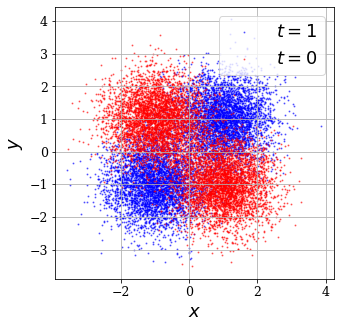

In [8]:
plot_data(d)

### Generate 1D data

In [9]:
N  = 60000
x  = np.random.uniform(-1, 1, N)

# targets
t = 3 * np.exp(-x/2) * np.sin(10*x)**2 + 2*np.cos(6*x) - 1.5

In [10]:
df = pd.DataFrame({'target': t, 'x': x})
jb.dump(df, 'data_02.db')
df[:5]

,target,x
0,-2.450893,-0.660321
1,-3.003031,0.639930
2,-1.862780,0.297934
3,0.190259,0.885593
4,0.253352,-0.953658


In [11]:
def plot_1d(x, t):
    
    # create an empty figure
    fig = plt.figure(figsize=(5, 5))
    fig.tight_layout()
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)
    ax.scatter(x, t, c='b', s=5)
    ax.set_xlabel('$x$', fontsize=FONTSIZE)
    ax.set_ylabel('$t$', fontsize=FONTSIZE)
    ax.grid(True, which="both", linestyle='-')
    plt.show()

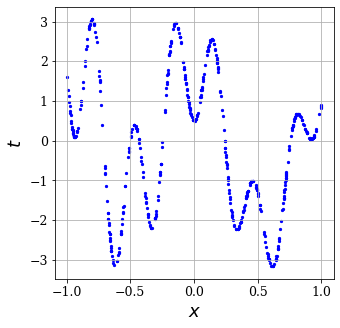

In [12]:
M = 500
plot_1d(x[:M], t[:M])

### Generate data for likelihood modeling example

\begin{align}
    p(x | a, c) & = |c| \frac{x^{ca - 1} \exp(-x^c)}{\Gamma(a)}
\end{align}

In [13]:
def plot_gengamma(a, c, xmin=0, xmax=10, xstep=0.01):
  
    # create an empty figure
    fig = plt.figure(figsize=(5, 4))
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    
    ax = fig.add_subplot(nrows,ncols,index)
    ax.set_xlabel('$x$', fontsize=FONTSIZE)
    ax.set_ylabel('$p(x|a, c)$', fontsize=FONTSIZE)
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([0.0, 1.6])
    
    x  = np.arange(xmin, xmax+xstep, xstep)
    kolor = ['red', 'orange', 'yellow', 
             'green', 'blue', 'indigo', 'violet']
    i = 0
    for ai, ci in zip(a, c):
        y = st.gengamma.pdf(x, ai, ci)
        ax.plot(x, y, color=kolor[i])
        i += 1
        if i >= len(kolor):
            i = 0
    fig.tight_layout()
    plt.show()

### Generate $t = 1$ data

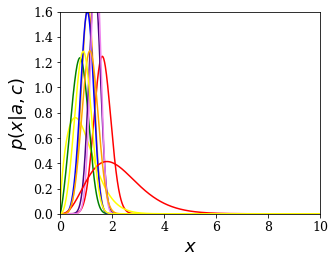

In [14]:
A = 1.5
C = 1.5
N = 55000

#a = st.gengamma.rvs(A, C, size=N)
#c = st.gengamma.rvs(A, C, size=N)
a = rnd.uniform(0.5, 4.5, N)
c = rnd.uniform(0.5, 4.5, N)
x = st.gengamma.rvs(a, c, size=N)
t = np.ones(N)

keep = (x > 1.e-8) & (x < 10)

N = 50000

a = a[keep][:N]
c = c[keep][:N]
x = x[keep][:N]
t = t[keep][:N]

df= pd.DataFrame({'target': t, 'x': x, 'a': a, 'c': c})
plot_gengamma(a[:10], c[:10])

### Generate $t = 0$ data

In [15]:
N = 55000

#a = st.gengamma.rvs(A, C, size=N)
#c = st.gengamma.rvs(A, C, size=N)
a = rnd.uniform(0.5, 4.5, N)
c = rnd.uniform(0.5, 4.5, N)
x = st.gengamma.rvs(A, C, size=N)
t = np.zeros(N)

keep = (x > 1.e-8) & (x < 10)

N = 50000

a = a[keep][:N]
c = c[keep][:N]
x = x[keep][:N]
t = t[keep][:N]

df= df.append(pd.DataFrame({'target': t, 'x': x, 'a': a, 'c': c}))
df[:5]

,target,x,a,c
0,1.0,1.585147,3.966548,2.646634
1,1.0,1.299548,1.552579,3.825829
2,1.0,1.783588,1.025634,1.635778
3,1.0,0.796917,0.666374,3.548656
4,1.0,1.231599,1.455697,3.788361


### Create a single data set with randomly shuffled rows

In [16]:
# frac=1 => all rows
# reset_index(drop=True) => drop original indices and create new ones
df = df.sample(frac=1).reset_index(drop=True)
jb.dump(df, 'data_03.db')
df[:5]

,target,x,a,c
0,1.0,1.236508,1.489001,4.231537
1,0.0,1.007293,3.771525,0.872288
2,1.0,1.115837,1.462106,4.107728
3,0.0,0.974543,4.114477,0.671938
4,1.0,1.319681,3.123314,2.155721


In [133]:
len(df)

100000